# Метод опорных векторов (SVM)

## Напоминание

[Sklearn mathematical formulation](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation)

Дана тренировачная выборка $x_i \in \mathbb{R}^p$, $y_i\in\{-1, 1\}$, $i=1,\ldots, n$. Хотим решить задачу классификации. Свели к задаче оптимизации:

\begin{equation}
    \frac{1}{2} ||w||^2 + С \sum_{i=1}^{n} \xi_i \longrightarrow \min_{w, b, \xi},\\
      \begin{split}
      \textrm {subject to }\ & y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i,\\
                             & \xi_i \geq 0.
      \end{split}
\end{equation}

Написали двойственную задачу:

\begin{equation}
    \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i\alpha_j y_i y_j \underbrace{\phi(x_i)^{T} \phi(x_j)}_{K(x_i, x_j)} - \sum_{i=1}^n \alpha_i \longrightarrow  \min_{\alpha}, \\
    \begin{split}
    \textrm {subject to }\ & \sum_{i=1}^n y_i \alpha_i = 0,\\
                           & 0 \leq \alpha_i \leq C.
    \end{split}
\end{equation}

**Важно!** Всё зависит только от $K(x_i, x_j)$, а не от обучающей выборки в первозданном виде.

В итоге решающее правило выглядит как:

\begin{equation}
y(x)= w^T\phi(x) + b = \sum_{x_i \in S} \alpha_i y_i K(x_i, x) + b \qquad \qquad (1)
\end{equation}

$S$ - множество опорных векторов.

**Важно!** Решающее правило зависит только от опорных векторов.

## Линейный SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Про скорость работы

Будем пользоваться `sklearn.svm.SVC`. Она использует под капотом библиотеку libsvm, которая работает медленнее, чем библиотека liblinear (находящаяся под капотом `sklearn.svm.linearSVC`). Но последняя не позволяет получить информацию о самих опорных векторах, поэтому будем для демонстрации пользоваться первой.

Ниже код, который сравнивает скорость работы упомянутых выше библиотек:

In [2]:
import sklearn.svm as svm
import sklearn.datasets as ds
from sklearn import metrics

In [3]:
import time

def get_model_times(model, sample_sizes=(100, 300, 1000, 3000, 10000, 30000)):
    times = []
    for sample_size in sample_sizes:
        t_0 = time.time()
        X, y = ds.make_classification(n_features=2, n_classes=2, n_samples=sample_size, n_redundant=0, random_state=1)
        model = model.fit(X, y)
        times.append(time.time() - t_0)
    return sample_sizes, times

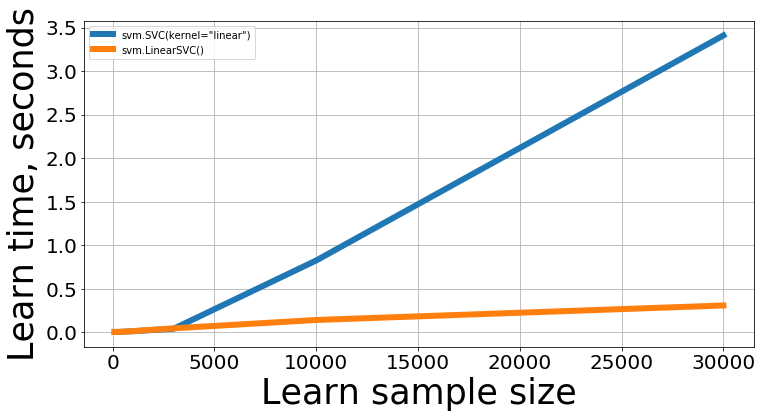

In [4]:
fig = plt.figure(figsize=(12, 6))
h1, = plt.plot(*get_model_times(svm.SVC(kernel='linear', C=1.0)), linewidth=6, label='svm.SVC(kernel="linear")')
h2, = plt.plot(*get_model_times(svm.LinearSVC(C=1.0)), linewidth=6, label='svm.LinearSVC()')

ax = plt.gca()
labels = ax.yaxis.get_majorticklabels() + ax.xaxis.get_majorticklabels()
for label in labels:
    label.set_fontsize(20)
ax.set_ylabel('Learn time, seconds', fontsize=35)
ax.set_xlabel('Learn sample size', fontsize=35)

plt.legend(handles=[h1, h2])
plt.grid('on')
plt.show()

### Про выбросы и опорные векторы

Напишем вспомогательную функцию для визуализации:

In [5]:
def plot_results(model, X, y, level=1.0, cmap=plt.cm.OrRd, use_decision_function=True, title='', 
                 plot_support_vectors=True):
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(1, figsize=(10, 8))
    plt.clf()

    if hasattr(model, "support_vectors_") and plot_support_vectors:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=150, facecolors='none', zorder=10, edgecolor='black')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=cmap, s=50, edgecolor='black')

    plt.axis('tight')
    
    def get_shifted_bounds(v, fraction=1.0/10):
        v_min, v_max = np.min(v), np.max(v)
        v_shift = np.abs(v_max - v_min) * fraction
        return v_min - v_shift, v_max + v_shift

    x_min, x_max = get_shifted_bounds(X[:, 0])
    y_min, y_max = get_shifted_bounds(X[:, 1])

    XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]

    if hasattr(model, "decision_function") and use_decision_function:
        Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])
    else:
        Z = model.predict(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(1, figsize=(10, 8))
    plt.pcolormesh(XX, YY, Z, cmap=cmap)
    if hasattr(model, "support_vectors_"):
        plt.contour(XX, YY, Z,
                    colors=['k', 'k', 'k'],
                    linestyles=['--', '-', '--'],
                    levels=[-level, 0, level])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)

    plt.xticks(())
    plt.yticks(())
    plt.show()

Посмотрим, как наш визуализатор работает на небольшой модельной задаче:

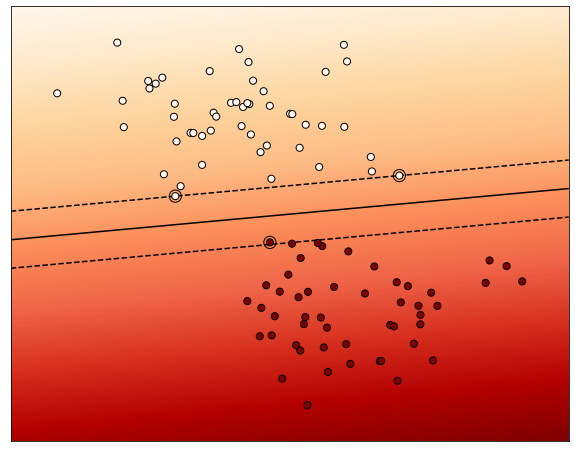

Accuracy on the training set: 1.0


In [6]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)
# X = np.concatenate((X, [[4, 8], [0, 0]]))
# y = np.concatenate((y, [1, 0]))

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0)

print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

**Задание 1 (0.5 балла)**. Изменяя код только в ячейке выше, добейтесь, чтобы accuracy на тренировочной выборке было равно 1.0. Менять гиперпараметры нельзя!
Обязательно поясните, что вы изменили и почему это помогло.

Закомментировал добавление выбросов в данные, получилось 1.0 accuracy. Убрал выбросы, потому что с ними невозможно было провести классификацию с linear ядром чтобы получить 1.0  accuracy.

В общем, по данным параметрам у нас генерируется крутая выборка чтобы моно было классифицировать прямой, так как центры для генерации объектов двух классов генерируются в поле 30 на 30 как я понимаю, а дисперсия для каждого класса равна только 1, так что, если не добавлять выбросов, то очень часто мы сможем разделить объекты так, что точность будет равна единице.

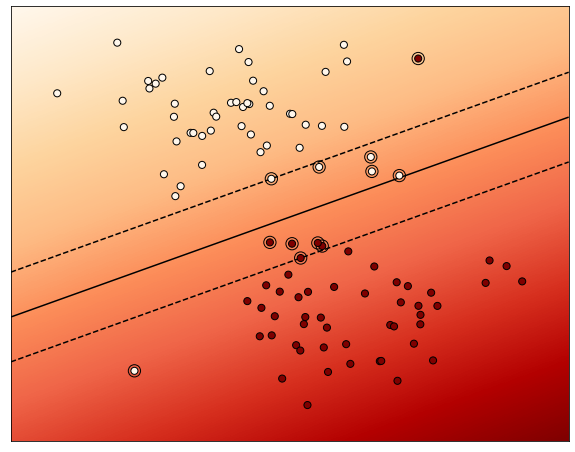

Accuracy on the training set: 0.9803921568627451


In [7]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)
X = np.concatenate((X, [[4, 8], [0, 0]]))
y = np.concatenate((y, [1, 0]))

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0)

print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

**Задание 2 (0.25 балла)**. Как посчитать качество для задачи выше, не вызывая никаких функций, а глядя лишь на исходный код и на картинку?

в коде видно что объектов у нас $100 + 2 = 102$, а на картинке видно, что мы $2$ объекта квалифировали неправильно,
следовательно точность = $$(102-2)/102$$

Давайте сравним, что поменяется, если мы выкинем часть объектов:

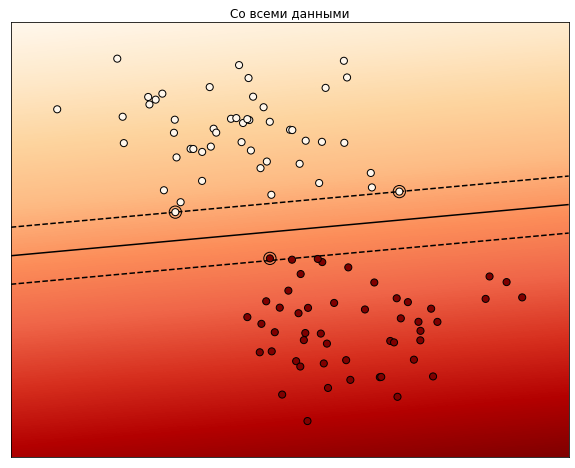

Accuracy on the training set: 1.0


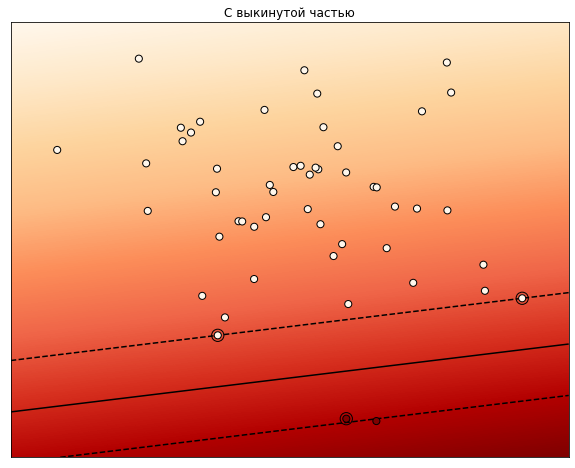

Accuracy on the training set: 1.0


In [8]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0, title='Со всеми данными')
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

# Выкидываем часть объектов, которые не являются опорными
p1 = np.array([0.57661937, 4.47488452])
p2 = np.array([3.73415974, 5.00131532])
p3 = np.array([1.90977788, 3.29011668])
det = lambda x, y: x[0]*y[1] - x[1]*y[0]
# some_up = [det(x, p2-p1) > det(p1, p2-p1)*1.01 for x in X]
some_up = [det(x, p2-p1) < det(p3, p2-p1)*0.96 for x in X]
X = X[some_up]
y = y[some_up]

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0, title='С выкинутой частью')

print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

**Задание 3 (0.5 балла)**. Как-то разделяющие поверхности выглядят уж слишком подозрительно похоже... А может они вообще полностью идентичны? Если да, то почему?

Разделяющие поверхности идентичны, т.к. на наше решающие правило влияют только опорные объекты, а мы все опорные объекты (3 штуки) в данном случае оставили.

Математические подробноси написаны тобой же в начале ноутбука, мол мы решаем двойственную задачу, и получается так, что альфа итые для неопорных объектов равны 0, вернее, опорные объекты по определению - это те, у которых коэффицент альфа (лямбда в других источниках) не равен нулю, и тогда в решающем правиле останутся лишь опорные элементы.

"Всё зависит только от  K(xi,xj) , а не от обучающей выборки в первозданном виде." - в начале ноутбука :)

### Про количество опорных векторов

Вспоминаем, как выглядит задача:

\begin{equation}
    \frac{1}{2} ||w||^2 + С \sum_{i=1}^{n} \xi_i \longrightarrow \min_{w, b, \xi},\\
      \begin{split}
      \textrm {subject to }\ & y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i,\\
                             & \xi_i \geq 0.
      \end{split}
\end{equation}

И геометрическую интерпретацию:

![](https://staesthetic.files.wordpress.com/2014/02/svm.png?w=1060)

Т.к. $\frac{2}{||w||^2}$ -- это ширина разделяющей поверхности, чем она шире -- тем больше в неё попадает опорных векторов. А шире она, если $C$ поменьше. Убедимся в этом на практике:

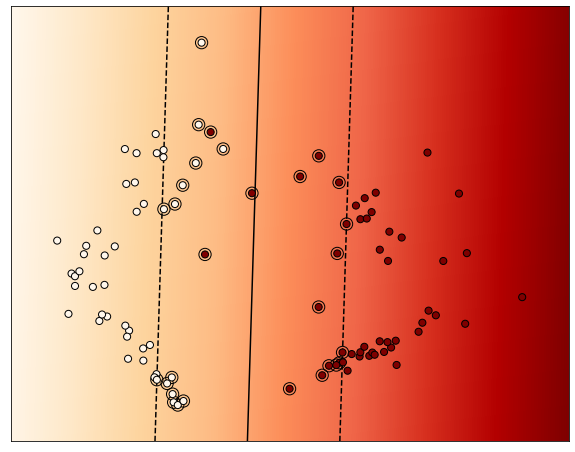

Accuracy on the training set: 0.97


In [9]:
X, y = ds.make_classification(n_features=2, n_classes=2, n_samples=100, n_redundant=0, random_state=1)

model = svm.SVC(kernel='linear', C=0.1)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

### Про линейно-неразделимую выборку

Окей, с линейно-разделимой выборкой понятно. А что, если ситуация жизненная, т.е. выборка не является линейно-разделимой?

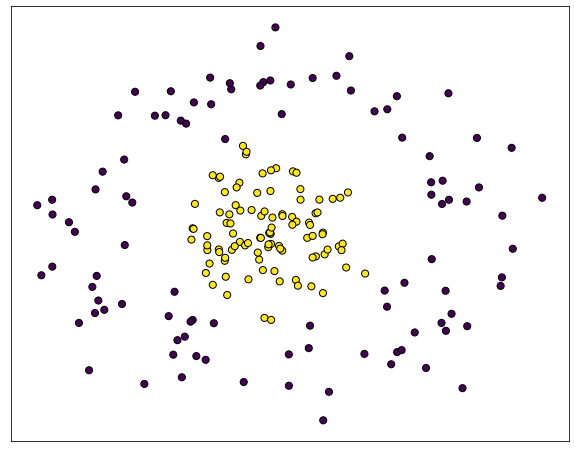

In [10]:
X, y = ds.make_circles(noise=0.2, factor=0.2, random_state=1, n_samples=200)

plt.figure(1, figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, s=50, edgecolor='black')
plt.xticks(())
plt.yticks(())
plt.show()

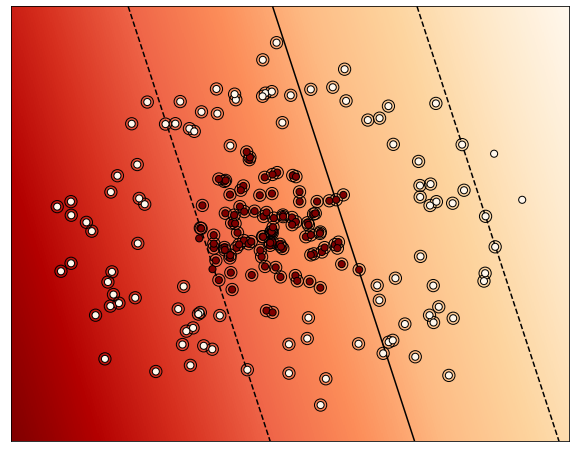

Accuracy on the training set: 0.675


In [11]:
model = svm.SVC(kernel='linear', C=10000)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))
first_model = model

Вы можете возразить: но мы же даже не подобрали гиперпараметры! Но, кажется, понятно, что линейным алгоритмом нормально решить задачу не выйдет :)

Упс... Задача вроде простая, но не для нашего SVM'а... Тем не менее, есть преобразование, которое сделает так, чтобы задача оказалась ему по плечу:
$$
(x, y) \to (x, y, x^2 + y^2)
$$

**Задание 4. (0.75 балла)** Спасите линейный SVM! Переведите объекты в другое признаковое пространство, используйте на новой выборке линейный SVM и визуализируйте то, что у вас получилось, в двухмерном пространстве. Кажется, для визуализации придётся скопировать и подхачить исходную функцию.

Accuracy on the training set: 1.0


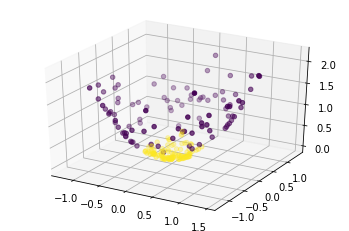

In [12]:
from mpl_toolkits import mplot3d

Z = np.array([[x[0] ** 2 + x[1] ** 2 for x in X]])
changed_X = np.concatenate((X, Z.T), axis = 1)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(changed_X[:, 0], changed_X[:, 1], changed_X[:, 2], c=y)

model = svm.SVC(kernel='linear', C=10)
model.fit(changed_X, y)
# plot_results(model, changed_X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(changed_X)))

1. C = 0.1 accuracy = 0.97
2. С = 1 accuracy = 0.995
3. C = 10 accuracy = 1.0

In [13]:
def my_plot_results(model, X, y, level=1.0, cmap=plt.cm.OrRd, use_decision_function=True, title='', 
                 plot_support_vectors=True):
        # plot the line, the points, and the nearest vectors to the plane
    plt.figure(1, figsize=(10, 8))
    plt.clf()

    if hasattr(model, "support_vectors_") and plot_support_vectors:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=150, facecolors='none', zorder=10, edgecolor='black')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=cmap, s=50, edgecolor='black')

    plt.axis('tight')
    
    def get_shifted_bounds(v, fraction=1.0/10):
        v_min, v_max = np.min(v), np.max(v)
        v_shift = np.abs(v_max - v_min) * fraction
        return v_min - v_shift, v_max + v_shift

    x_min, x_max = get_shifted_bounds(X[:, 0])
    y_min, y_max = get_shifted_bounds(X[:, 1])
    z_min, z_max = get_shifted_bounds(X[:, 2])

    XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
    ZZ = XX*XX + YY*YY
    a = np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()]
    # print(np.shape(a))
    
    if hasattr(model, "decision_function") and use_decision_function:
        Z = model.decision_function(a)
    else:
        Z = model.predict(a)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(1, figsize=(10, 8))
    plt.pcolormesh(XX, YY, Z, cmap=cmap)
    
    if hasattr(model, "support_vectors_"):
        plt.contour(XX, YY, Z,
                    colors=['k', 'k', 'k'],
                    linestyles=['--', '-', '--'],
                    levels=[-level, 0, level])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)

    plt.xticks(())
    plt.yticks(())
    plt.show()

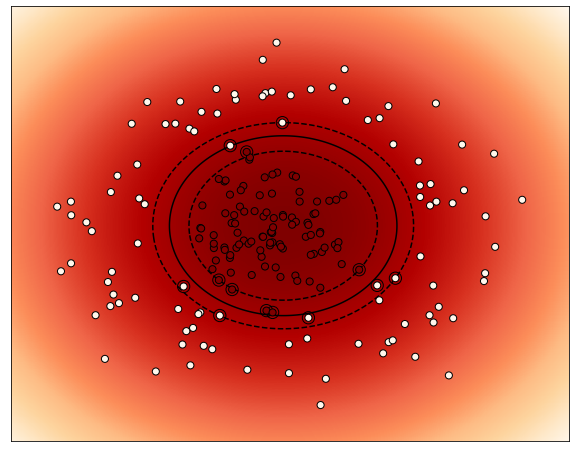

In [14]:
my_plot_results(model, changed_X, y, level=1.0)

## Ядра - чистый изумруд!

Но для каждого случая подбирать признаковое пространство - это очень сложно. Да и вообще, если вспомнить про двойственную задачу, то становится ясно, что нам нужно даже не сами признаки знать в новом пространстве, а лишь уметь вычислять скалярное произведение.

Воспользуемся ядровым переходом с простым полиномиальным ядром. Напоминание:

$$
K(x,y) = (x^\mathsf{T} y + c)^{d}
$$

Попробуем применить параметры по-умолчанию:

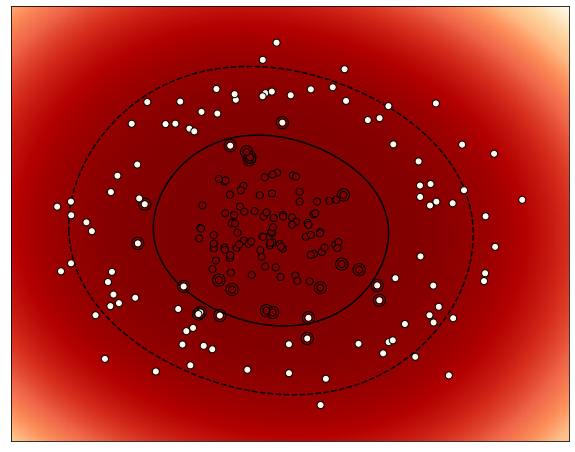

Accuracy on the training set: 0.985


In [15]:
model = svm.SVC(kernel='poly', C=1, degree=4)
model.fit(X, y)
plot_results(model, X, y, level=10.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

Опа, такой SVM нам подходит!

![](https://i.ibb.co/4Mc322f/kernel-trick.png)

А теперь задачка посложнее:

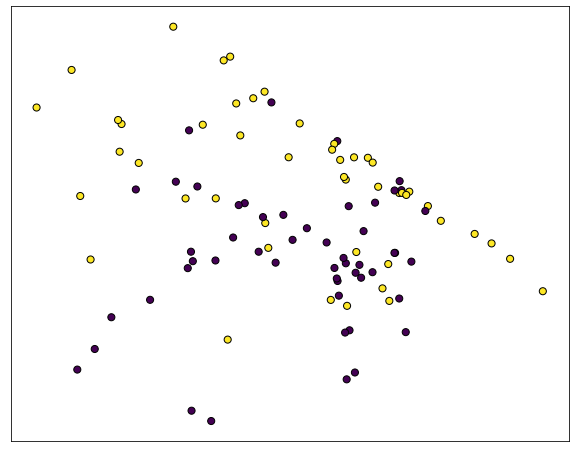

In [16]:
X, y = ds.make_classification(n_features=2, n_classes=2, n_samples=100, n_redundant=0, random_state=3, flip_y=0.3)

plt.figure(1, figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, s=50, edgecolor='black')
plt.xticks(())
plt.yticks(())
plt.show()

Посмотрим, как меняется картинка классификации в зависимости от параметров $C$ и $\gamma$:

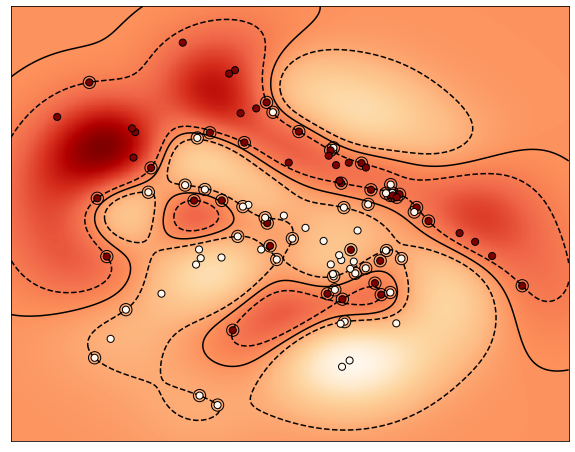

Accuracy on the training set: 0.87


In [17]:
model = svm.SVC(kernel='rbf', C=100, gamma=1)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

## Про переобучение

Рассмотрим ещё одну небольшую модельную задачу ([данные](https://yadi.sk/d/Yd1Xipl2WOFdHQ)):

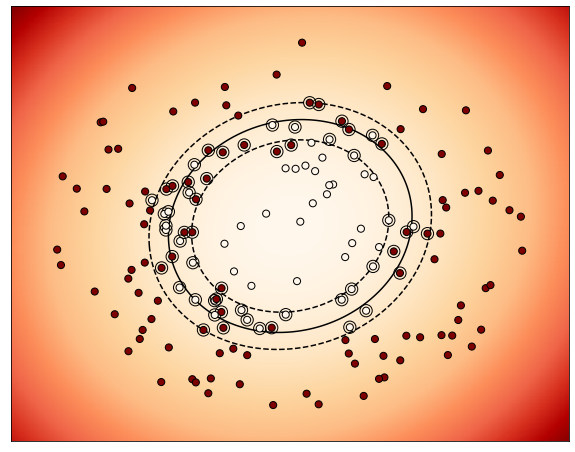

Accuracy on the training set: 0.8292682926829268


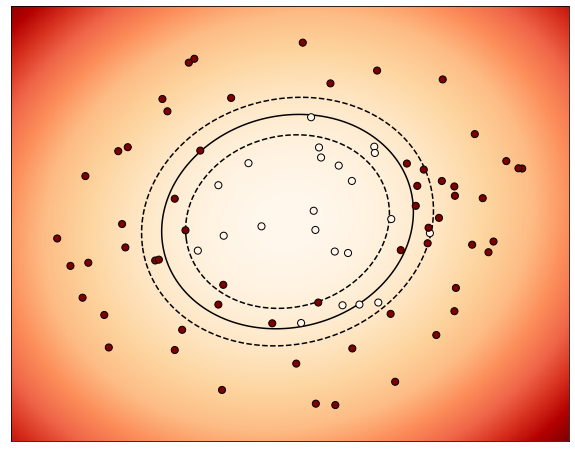

Accuracy on the testing set: 0.8780487804878049


In [18]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('data_svm.csv')
X = df[['X1', 'X2']].values
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

model = svm.SVC(kernel='poly', degree=2, C=100)
model.fit(X_train, y_train)

plot_results(model, X_train, y_train, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model.predict(X_train)))
plot_results(model, X_test, y_test, level=1.0, plot_support_vectors=False)
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model.predict(X_test)))

Как вы можете заметить, значения точности не сильно отличаются для обучающей и тестовой выборки. Но так будет не обязательно... И вам предстоит это доказать!

**Задание 5 (1 балл).** Добейтесь ряда разных эффектов, перебирая параметры классификатора SVM:
* как можно бОльшего недообучения: когда качество и на обучающей, и на тестовой выборке очень плохое
* как можно бОльшего переобучения: когда качество на обучающей выборке очень хорошее, а на тестовой не очень хорошее
* оптимального обучения: когда и на обучающей, и, главное, на тестовой выборке, всё окей

Подберите параметры, посчитайте соответствующие качества и визуализируйте получившиеся модели. Конкретных требований к числам нет, постарайтесь сделать всё, что в ваших силах, для минимизации и максимизации их!

рассуждения ниже
Accuracy on the training set: 0.6829268292682927
Accuracy on the testing set: 0.7317073170731707


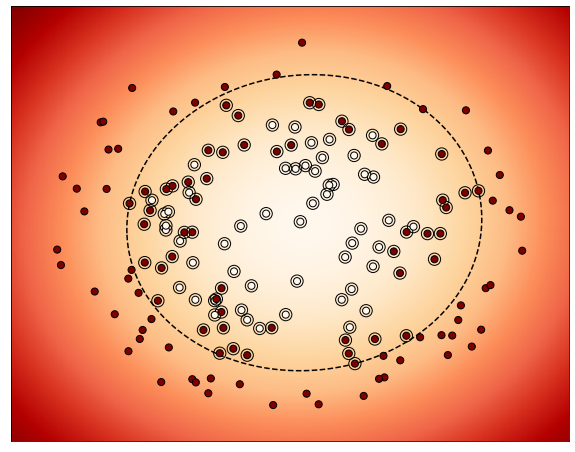

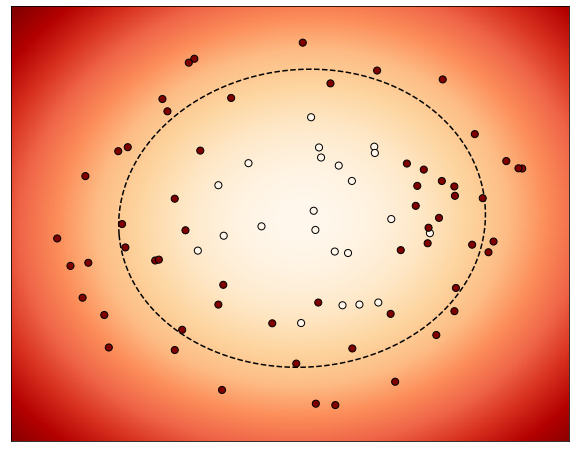

In [89]:
model = svm.SVC(kernel='rbf', C=1, gamma=1)
model.fit(X_train, y_train)

print("рассуждения ниже")
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model.predict(X_train)))
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model.predict(X_test)))
plot_results(model, X_train, y_train, level=1.0)
plot_results(model, X_test, y_test, level=1.0, plot_support_vectors=False)

### Недообучение
0. плохо на train, плохо на test
1. Accuracy on the training set: $0.6829268292682927 = a_1$
2. Accuracy on the testing set: $0.7317073170731707 = a_2$

Это минимальные показатели на обоих выборках, т.к. мы просто говорим, что все объекты принадлежат одному классу. Т.к. классификация бинарная, то значения 1 - $a_1$ и $a_1$ имеют одинаковый смысл, как и для $a_2$.

рассуждения ниже
Accuracy on the training set: 1.0
Accuracy on the testing set: 0.7560975609756098


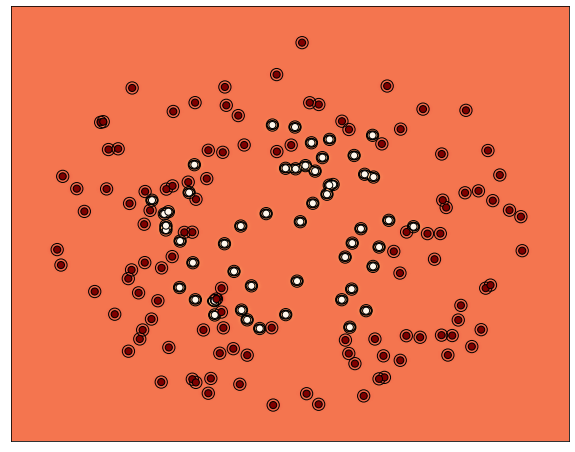

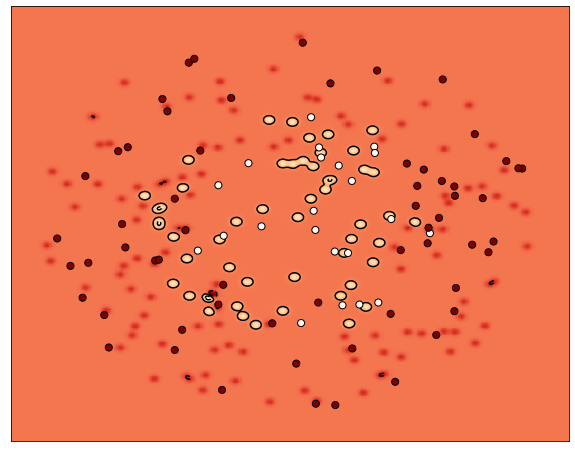

In [97]:
model = svm.SVC(kernel='rbf', C=10000, gamma=10000)
model.fit(X_train, y_train)

print("рассуждения ниже")
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model.predict(X_train)))
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model.predict(X_test)))
plot_results(model, X_train, y_train, level=1.0)
plot_results(model, X_test, y_test, level=1.0, plot_support_vectors=False)

### Переобучение 
0. хорошо на train, плохо на test

1. Accuracy on the training set: $1.0 = a_1$
2. Accuracy on the testing set: $0.7560975609756098 = a_2$

Переобучение на выборке для обучения видно на картинке, ну и мы выдаём максимально возможный результат для неё - 1.0.

Теперь посмотрим на $a_2$ и сравним со значеним $a_2$ из прошлого пункта про Недообучение, где мы получили, что минимальный плохой результат равен $0.7317073170731707$. Тогда разница между результатами равна $0.0243902439$, всего лишь настолько переобученная модель лучше недообученной на тестовой выборке. Хотя повысить результативность даже на $0.1$ не составляет особого труда.

In [163]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
import scipy.stats

In [164]:
par = {'C': scipy.stats.expon(scale=100000), 'gamma': scipy.stats.expon(scale=1000), 'kernel': ['rbf']}

svc = svm.SVC()
clf = RandomizedSearchCV(svc, par, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'C': 331491.21820538136, 'gamma': 483.6021009022533, 'kernel': 'rbf'}

Accuracy on the training set: 1.0
Accuracy on the testing set: 0.8780487804878049
удивительно что они совпали, но я посмотрел другие метрики, и там разные числа, всё хорошо


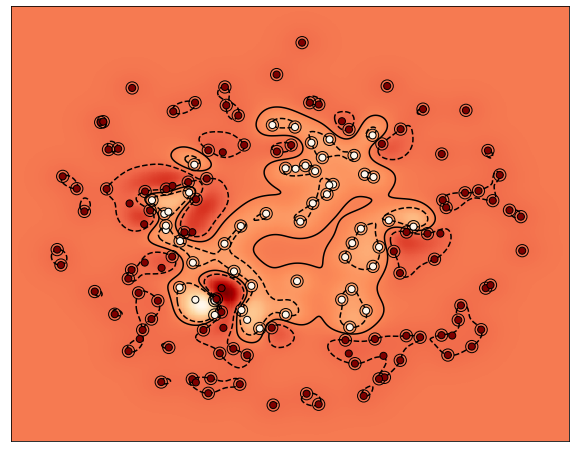

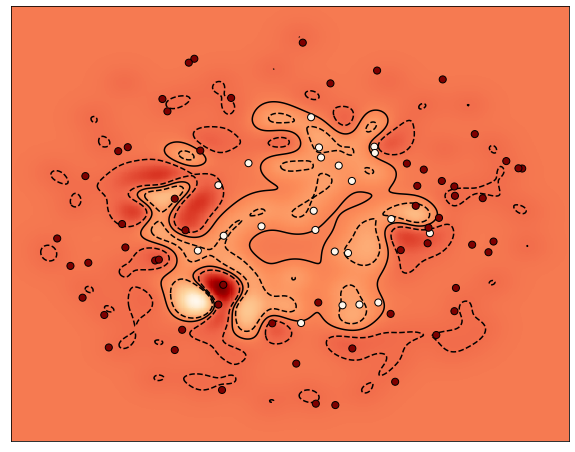

In [165]:
model = svm.SVC(kernel='rbf',  C=331491.21820538136, gamma=483.6021009022533)
model.fit(X_train, y_train)

print('Accuracy on the training set:', metrics.accuracy_score(y_train, model.predict(X_train)))
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model.predict(X_test)))
print('удивительно что они совпали, но я посмотрел другие метрики, и там разные числа, всё хорошо')
plot_results(model, X_train, y_train, level=1.0)
plot_results(model, X_test, y_test, level=1.0, plot_support_vectors=False)

### Оптимальное решение 
0. хорошо на train, хорошо на test

1. Accuracy on the training set: $1.0 = a_1$
2. Accuracy on the testing set: $0.8780487804878049 = a_2$

Ну, на трейне единица аж, тут как бы лучше не сделать. Тестовая выборка, думаю можно и получше, значительно при том, хотя в общем результат неплохой, думаю в домашке получше разберусь как находить гиперпараметры.

# Категориальные признаки

Как правило, выделяют следующие типы признаков у объекта:
* *числовые/количественные*: имеют физический смысл, выраженный числом
* *порядковые*: принимают значения из конечного упорядоченного множества
* *категориальные*: принимают значение из конечного множества, не обязательно упорядоченного
* *бинарные*: принимают значения из {0, 1}

Проделаем полезное упражнение: для каждого из приведённых ниже признаков определим их тип

Про пациента больницы:
* пол пациента
* артериальное давление
* основное заболевание
* тяжесть состояния (удовлетворительное, средней тяжести, тяжёлое, крайне тяжёлое)

Про заёмщика:
* наличие непогашенной задолженности
* ежемесячный доход
* профессия
* текст сопроводительного письма

Рассмотрим основные способы учёта категориальных признаков

## Не учитывать

![](https://i.ibb.co/swf0GMG/mem.jpg)

##  Label Encoder

Один из первых приходящих на ум методов - это превратить категории в числа (например, с помощью [`sklearn.preprocessing.LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), а дальше ничего и не делать.

В числа превращать в любом случае надо, а вот использовать их "как есть" - идея не самая продуктивная.

## One-hot-encoding

Пожалуй, самый популярный способ. Суть такая:
* берём признак
* считаем количество различных его значений, пусть оно равно $d$
* превращаем признак в $d$ новых бинарных, где у каждого объекта 1 стоит на месте, равном значению признака

Некоторые библиотеки (такие, как vowpal wabbit) поддерживают one-hot-encoding из коробки, некоторые предлагают специальные методы для явного превращения (такие как [`sklearn.preprocessing.OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) или [`pandas.get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html))

## Признаки-счётчики

Идея в том, чтобы кодировать признак не напрямую, а опосредовано через другие количественные признаки. Проще всего пояснить на примере.

Рассмотрим небольшую выборку:
![](https://i.ibb.co/Ctx9c5R/Screenshot-from-2021-03-09-10-40-48-copy.png)

Как же нам закодировать города?

Наверное, сам город нас не очень волнует. Гораздо более интересно, насколько большой средний доход в городе и насколько распространена в этом городе соответствующая должность (ведь спрос рождает предложение). Давайте эти статистики и посчитаем!

![](https://i.ibb.co/mJzS6QY/Screenshot-from-2021-03-09-10-40-48.png)

Несколько нюансов:
* в качестве признака для подсчёта статистики можно брать и целевую переменную
* считать статистики нужно только по обучающей выборке